# **Portfolio Optimization Documentation**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

In [ ]:
# Data preparation –––––

# Read stock prices from Excel file (each sheet is a ticker)
dictPRICES = pd.read_excel('data/stocks_data.xlsx', sheet_name=None)

# Get list of tickers from the dictionary keys
listTICKERS = list(dictPRICES.keys())

# Create a DataFrame for closing prices
dfPRICES = pd.DataFrame()
dfPRICES['Date'] = dictPRICES[listTICKERS[0]]['Date']

# Populate the DataFrame with closing prices for each ticker
for ticker in listTICKERS:
    dfPRICES[ticker] = dictPRICES[ticker]['Close']

In [ ]:
# Portfolio optimization –––––

# Prepare price DataFrame
df = dfPRICES.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()
assets = df.columns.tolist()

# Daily simple returns
ret_d = df.pct_change().dropna()

# Annualize (252 trading days)
TRADING_DAYS = 252
mu = ret_d.ewm(span=TRADING_DAYS).mean().iloc[-1] * TRADING_DAYS
Sigma = ret_d.cov() * TRADING_DAYS

# Vectors and matrix helpers
ones = np.ones(len(assets))
Sigma_inv = np.linalg.inv(Sigma.values)
mu_vec = mu.values

A = ones @ Sigma_inv @ ones
B = ones @ Sigma_inv @ mu_vec
C = mu_vec @ Sigma_inv @ mu_vec
D = A*C - B**2

# Global Minimum-Variance Portfolio (GMV)
w_gmv = (Sigma_inv @ ones) / A
mu_gmv = float(w_gmv @ mu_vec)
sig_gmv = float(np.sqrt(w_gmv @ Sigma.values @ w_gmv))

# Efficient Frontier (unconstrained, varying target return)
mu_assets = mu_vec
sig_assets = np.sqrt(np.diag(Sigma.values))

mu_min = min(mu_gmv, mu_assets.min())
mu_max = max(mu_assets.max(), mu_gmv)
mu_targets = np.linspace(mu_min, mu_max, 200)

frontier_mu = []
frontier_sig = []

for mu_p in mu_targets:
    # Closed-form weights for target return mu_p
    lam = (C - B*mu_p) / D
    gam = (A*mu_p - B) / D
    w = Sigma_inv @ (lam*ones + gam*mu_vec)
    mu_front = float(w @ mu_vec)
    sig_front = float(np.sqrt(w @ Sigma.values @ w))
    frontier_mu.append(mu_front)
    frontier_sig.append(sig_front)

# Tangency Portfolio & CML (with annual risk-free rate)
Rf = 0.02 # 2% annual risk-free rate
excess = mu_vec - Rf*ones
w_tan_unnorm = Sigma_inv @ excess
w_tan = w_tan_unnorm / (ones @ w_tan_unnorm)
mu_tan = float(w_tan @ mu_vec)
sig_tan = float(np.sqrt(w_tan @ Sigma.values @ w_tan))
sharpe_tan = (mu_tan - Rf) / sig_tan

# Capital Market Line from sigma=0 to a bit beyond the frontier's max risk
sigma_line = np.linspace(0, max(max(frontier_sig), sig_tan)*1.05, 100)
cml = Rf + sharpe_tan * sigma_line

# Single-asset points (as portfolios fully invested in one asset)
mu_single = mu_assets
sig_single = sig_assets


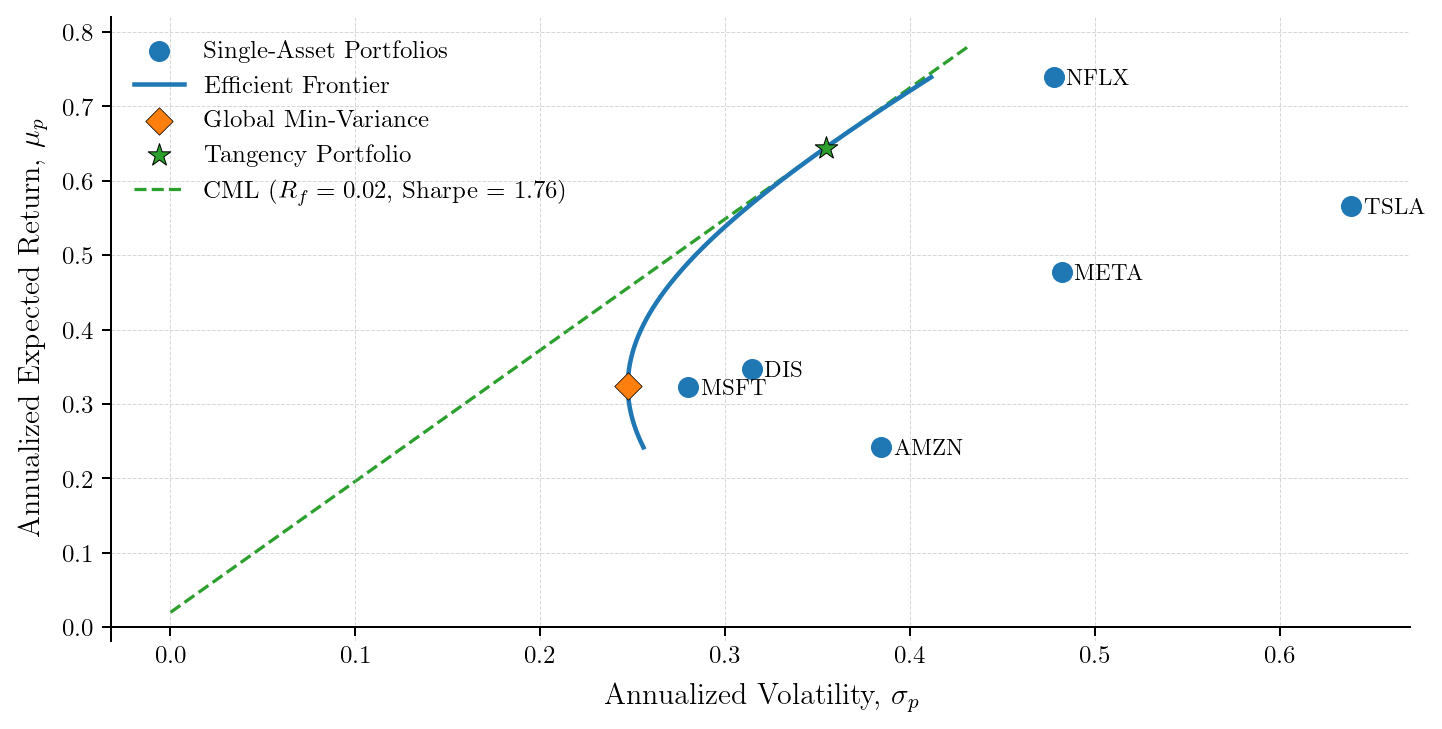

In [78]:
# Plotting Efficient Frontier and CML –––––

# Plot settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.8,
    "grid.linewidth": 0.4,
    "figure.dpi": 180
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Single assets
ax.scatter(sig_single, mu_single, s=55, marker='o', color='C0', label='Single-Asset Portfolios', zorder=3)
for i, name in enumerate(assets):
    ax.annotate(name, (sig_single[i], mu_single[i]), xytext=(5, -3), textcoords='offset points', fontsize=9, family='serif')

# efficient frontier
ax.plot(frontier_sig, frontier_mu, color='C0', lw=1.8, label='Efficient Frontier', zorder=2)

# GMV point
ax.scatter(sig_gmv, mu_gmv, s=60, marker='D', color='C1', edgecolor='k', linewidth=0.3, label='Global Min-Variance', zorder=4)

# Tangency portfolio
ax.scatter(sig_tan, mu_tan, s=90, marker='*', color='C2', edgecolor='k', linewidth=0.4, label='Tangency Portfolio', zorder=5)

# Capital Market Line
ax.plot(sigma_line, cml, color='C2', ls='--', lw=1.3, label=rf'CML ($R_f={Rf}$, Sharpe = {sharpe_tan:.2f})', zorder=1)

# Clean axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)

# Axis labels & title
ax.set_xlabel(r'Annualized Volatility, $\sigma_p$', labelpad=6)
ax.set_ylabel(r'Annualized Expected Return, $\mu_p$', labelpad=6)
#ax.set_title(r'\textbf{Modern Portfolio Theory: Efficient Frontier and Capital Market Line}')

# Legend
ax.legend(frameon=False, loc='upper left')

# Tick formatting
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}'))

# Show and save plot
plt.tight_layout(pad=0.5)
plt.savefig('documentation/figures/efficient_frontier_cml.png', dpi=300)
plt.show()

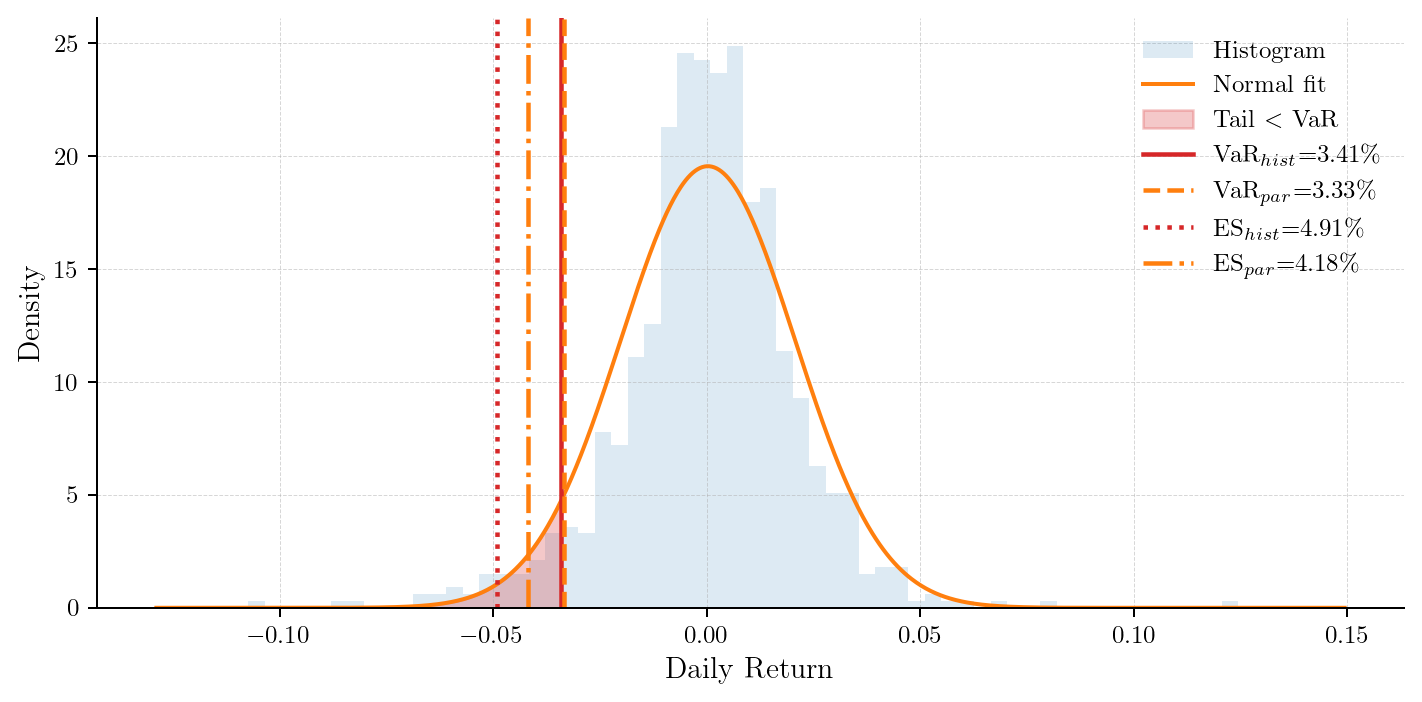

In [77]:
# Plotting Portfolio VaR and ES –––––

# Data preparation
df = dfPRICES.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()
prices = df.astype(float)

logret = np.log(prices).diff().dropna()
w = np.ones(logret.shape[1]) / logret.shape[1]
rp = (logret @ w).rename('Portfolio')

# Parameters for VaR / ES calculations
alpha = 0.95
p_tail = 1 - alpha
mu, sigma = rp.mean(), rp.std(ddof=1)
z = norm.ppf(p_tail)

# Historical (empirical) VaR / ES
q_hist = rp.quantile(p_tail) # 5th percentile of returns
VaR_hist = -q_hist # as a positive loss
ES_hist = -rp[rp <= q_hist].mean() # as a positive loss

# Parametric (Normal) VaR / ES (on log-returns)
VaR_par = -(mu + z * sigma) # positive loss
ES_par = -(mu - sigma * norm.pdf(z) / p_tail) # positive loss


# Plotting
fig, ax = plt.subplots(figsize=(8, 4))

# Histogram of daily returns
bins = 60
n, b, _ = ax.hist(rp, bins=bins, density=True, alpha=0.15, edgecolor='none', label='Histogram')

# Overlay fitted normal density
x = np.linspace(rp.min()*1.2, rp.max()*1.2, 1000)
pdf = norm.pdf(x, loc=mu, scale=sigma)
ax.plot(x, pdf, lw=1.6, label='Normal fit')

# Shade left tail beyond HIST VaR threshold
x_fill = x[x <= q_hist]
ax.fill_between(x_fill, norm.pdf(x_fill, mu, sigma), alpha=0.25, color='C3', label='Tail $<$ VaR')

# Vertical markers: VaR & ES (Historical and Parametric)
def vline(xpos, label, color, ls='-'):
    ax.axvline(xpos, color=color, lw=1.8, ls=ls, label=label)

vline(q_hist,  f'VaR$_{{hist}}$={VaR_hist*100:.2f}\\%', 'C3')
vline(-VaR_par, f'VaR$_{{par}}$={VaR_par*100:.2f}\\%', 'C1', ls='--')

vline(-ES_hist, f'ES$_{{hist}}$={ES_hist*100:.2f}\\%', 'C3', ls=':')
vline(-ES_par,  f'ES$_{{par}}$={ES_par*100:.2f}\\%', 'C1', ls='-.')

# Clean axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)

# Axis labels & title
#ax.set_title(r'\textbf{Portfolio Daily VaR and Expected Shortfall (95\%)}')
ax.set_xlabel(r'Daily Return')
ax.set_ylabel('Density')

# Legend
ax.legend(frameon=False, ncol=1)

# Show and save plot
plt.tight_layout()
plt.savefig('documentation/figures/portfolio_var_es.png', dpi=300)
plt.show()
